Brian Dannenmueller
Problem: Produce a machine learning based model that generates predictions for student exam scores based on a number of attributes, or features. Identify which features contribute the most to acheive a high-quality education. 

##### Data Preparation:
    1. Checked dimensions of data and created summary statistics to determine how to process the data. 
    2. Dropped the rows missing data in the absences column (only a handful in each data set)
    3. One-hot coded categorical data so that the knn algorithm can use it
    4. Normalize the data after running baseline models.

##### Metrics: 
Since this is a regression problem, so will will be using the r^2 metric to test the effectiveness of each model.  
   
##### Baseline Performance: 
   -- The R^2 metric was measured against the average grade.
      Portuguese Baseline R-squared Score: -0.009736606855753172
      Mathematics Baseline R-squared Score: -0.03770254105919246
    
   -- All of the untuned models were fairly inaccurate, with the decision trees and Portuguese knn performing worse than           random. The math knn and math random forest models did best. Here are their r-squared values: 
   
        Portuguese KNN: -0.21
        Portuguese Tree: -0.94
        Mathematics KNN: 0.20
        Mathematics Tree:-0.63
        Portuguese Random Forest: 0.048
        Mathematics Random Forest: 0.23

##### Model Planning and Execution: 
Each dataset will be tackled with the following algorithms: k nearest neighbors, decision tree, and random           forest. For knn -- number of neighbors and distance weighting were utilized.  For the decision trees -- max           depth, min_samples_split, and min_samples_leaf were tuned. For the random forest -- number of trees, max depth,       and max features were all tuned to great effect. 
  
##### Process: 
My overall strategy was to identify which models produced the most useful results given the best possible parameters and then visualize these models in order to identify which features have the most influence on model performance. I utilized the scikit-learn online documentation to find parameters to tune and experimented with several of the parameters of each model and kept the ones with the most effect. I shared parameters from must best Portuguese models with the Mathematics models and tuned them again, with less effort since very little adjustment needed to be made. 
I verified my results by examining visualizations showing how the decision trees and random forests determined the G3 target and making sure that they made sense -- which they did. 

##### Results: 
Visualizations appear in Section IV of the code. However, to summarize, failures was the most influential factor among all of the decision tree and random forest models, where students that failed prior classes were more likely to have lower grades. Surprisingly, zero absences was generally correlated with lower grades. Students aspiring to enter higher education generally had higher grades. 

##### Recommendation: 
The government should focus its research on how the prior failures could result in the feedback loop of continued poor performance. It should also investigate why zero absences are sometimes correlated with lower grades (the opposite of what is expected). On a more concrete note, lower student loan interest rates could make a college education more attainable for more students. Hope for higher education can be a powerful positive motivator. In general, these results provide breadcrumbs for further investigation rather than immediate policy change, as these correlations do not point to causation. 

##### Insights: 
I noticed that we were able to achieve the lowest error rate with models built from the mathematics student data. This variation in error rate between mathematics student models and Portuguese student models merits more investigation. Does this have to do with the method by which data is gathered? Is there more random noise in the Portuguese student data set, which would cause more innaccurate models, or is there some other cause?


In [1]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import graphviz


### Section I: Data Exploration and Preparation ###

In [2]:
por = pd.read_csv('student-por.csv')
por.shape

(649, 31)

In [3]:
por.head()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,4.0,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,2.0,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,6.0,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,NaN,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,0.0,13


In [4]:
por.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,643.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.693624,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.648827,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000


In [5]:
mat = pd.read_csv('student-mat.csv')

In [6]:
mat.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,389.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.796915,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.032947,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,20.000000


In [7]:
por.dropna(inplace=True)
mat.dropna(inplace=True)
#only five rows and six rows are lost for the por and math data sets, respectively, not much of a loss. 
#These came from the absences column. 

In [8]:
#Change to one-hot encoding

por_dummies = pd.get_dummies(por)
math_dummies = pd.get_dummies(mat)

In [9]:
predictors = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
       'school_GP', 'school_MS', 'sex_F', 'sex_M', 'address_R', 'address_U',
       'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Mjob_at_home',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
       'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services',
       'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other',
       'reason_reputation', 'guardian_father', 'guardian_mother',
       'guardian_other', 'schoolsup_no', 'schoolsup_yes', 'famsup_no',
       'famsup_yes', 'paid_no', 'paid_yes', 'activities_no', 'activities_yes',
       'nursery_no', 'nursery_yes', 'higher_no', 'higher_yes', 'internet_no',
       'internet_yes', 'romantic_no', 'romantic_yes']
target = 'G3'

train_por, test_por, train_p_sln, test_p_sln = \
    train_test_split(por_dummies[predictors], por_dummies[target], test_size = 0.2, random_state = 41)


train_mat, test_mat, train_m_sln, test_m_sln = \
    train_test_split(math_dummies[predictors], math_dummies[target], test_size = 0.2, random_state = 41)


### Section II: Baseline Performance ###

In [10]:
##Baseline is based off of calculating the R-squared score using solely the mean G3 value to predict future values. 
##Improvements will be measured as the difference between this baseline value and the new model value. 
mean = por['G3'].mean()
por_means = []
for i in range(len(test_p_sln)):
    por_means.append(mean)
pd.Series(por_means)
    
print("Portuguese Baseline R-squared Score:", metrics.r2_score(test_p_sln, por_means))

Portuguese Baseline R-squared Score: -0.009736606855753172


In [11]:
mean = mat['G3'].mean()
mat_means = []
for i in range(len(test_m_sln)):
    mat_means.append(mean)
pd.Series(mat_means)
    
print("Mathematics Baseline R-squared Score:", metrics.r2_score(test_m_sln, mat_means))

Mathematics Baseline R-squared Score: -0.03770254105919246


In [12]:
#Ready to start basic modeling without normalization/tuned parameters
#We'll run Portuguese and Mathematics models separately for each regressor 
#algorithm (knn, Decision Tree, Random Forest)

knn_por = neighbors.KNeighborsRegressor()
knn_por.fit(train_por, train_p_sln)
knn_por_predictions = knn_por.predict(test_por)

print("___PREDICTED___ ___ACTUAL___")
for i in range(10):
    print("   ", knn_por_predictions[i],"\t\t    ", test_p_sln.iloc[i])
    
print()
print("R-squared Score:", metrics.r2_score(test_p_sln, knn_por_predictions))

print(len(knn_por_predictions), len(test_p_sln))


___PREDICTED___ ___ACTUAL___
    10.8 		     11
    15.8 		     9
    11.4 		     10
    14.2 		     12
    13.6 		     10
    12.0 		     11
    10.8 		     15
    11.4 		     0
    14.8 		     10
    12.2 		     11

R-squared Score: -0.21338759733664392
129 129


In [13]:
knn_mat = neighbors.KNeighborsRegressor()
knn_mat.fit(train_mat, train_m_sln)
knn_mat_predictions = knn_mat.predict(test_mat)

print("___PREDICTED___ ___ACTUAL___")
for i in range(10):
    print("   ", knn_mat_predictions[i],"\t\t    ", test_m_sln.iloc[i])
    
print()
print("R-squared Score:", metrics.r2_score(test_m_sln, knn_mat_predictions))

___PREDICTED___ ___ACTUAL___
    11.2 		     10
    10.0 		     16
    8.0 		     11
    13.2 		     8
    10.0 		     10
    13.0 		     20
    9.8 		     18
    4.8 		     8
    10.0 		     9
    14.6 		     18

R-squared Score: 0.2033955105912112


In [14]:
tree_por = tree.DecisionTreeRegressor()
tree_por.fit(train_por, train_p_sln)
tree_por_predictions = tree_por.predict(test_por)

print("___PREDICTED___ ___ACTUAL___")
for i in range(10):
    print("   ", tree_por_predictions[i],"\t\t    ", test_p_sln.iloc[i])
    
print()
print("R-squared Score:", metrics.r2_score(test_p_sln, tree_por_predictions))

___PREDICTED___ ___ACTUAL___
    12.0 		     11
    16.0 		     9
    14.0 		     10
    12.0 		     12
    12.0 		     10
    13.0 		     11
    15.0 		     15
    10.0 		     0
    18.0 		     10
    10.0 		     11

R-squared Score: -1.0981971560771924


In [15]:
tree_mat = tree.DecisionTreeRegressor()
tree_mat.fit(train_mat, train_m_sln)
tree_mat_predictions = tree_mat.predict(test_mat)

print("___PREDICTED___ ___ACTUAL___")
for i in range(10):
    print("   ", tree_mat_predictions[i],"\t\t    ", test_m_sln.iloc[i])
    
print()
print("R-squared Score:", metrics.r2_score(test_m_sln, tree_mat_predictions))

___PREDICTED___ ___ACTUAL___
    11.0 		     10
    13.0 		     16
    12.0 		     11
    13.0 		     8
    10.0 		     10
    16.0 		     20
    11.0 		     18
    0.0 		     8
    13.0 		     9
    11.0 		     18

R-squared Score: -0.492623037200969


In [16]:
forest_por = RandomForestRegressor()
forest_por.fit(train_por, train_p_sln)
forest_por_predictions = forest_por.predict(test_por)

print("___PREDICTED___ ___ACTUAL___")
for i in range(10):
    print("   ", forest_por_predictions[i],"\t\t    ", test_p_sln.iloc[i])
    
print()
print("R-squared Score:", metrics.r2_score(test_p_sln, forest_por_predictions))

___PREDICTED___ ___ACTUAL___
    12.0 		     11
    12.5 		     9
    12.7 		     10
    13.7 		     12
    14.2 		     10
    12.5 		     11
    12.7 		     15
    10.0 		     0
    14.7 		     10
    14.6 		     11

R-squared Score: -0.04156472181469373


/opt/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [17]:
forest_mat = RandomForestRegressor()
forest_mat.fit(train_mat, train_m_sln)
forest_mat_predictions = forest_mat.predict(test_mat)

print("___PREDICTED___ ___ACTUAL___")
for i in range(10):
    print("   ", forest_mat_predictions[i],"\t\t    ", test_m_sln.iloc[i])
    
print()
print("R-squared Score:", metrics.r2_score(test_m_sln, forest_mat_predictions))

___PREDICTED___ ___ACTUAL___
    10.7 		     10
    11.2 		     16
    9.9 		     11
    11.5 		     8
    10.4 		     10
    11.3 		     20
    10.5 		     18
    7.8 		     8
    8.4 		     9
    11.1 		     18

R-squared Score: 0.39368268521445915


/opt/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Section III: Model Parameter Tuning ###

In [18]:
scaler = StandardScaler()
scaler.fit(train_por)
norm_train_por = scaler.transform(train_por)
norm_test_por = scaler.transform(test_por)
norm_train_mat = scaler.transform(train_mat)
norm_test_mat = scaler.transform(test_mat)

In [19]:
knn_por = neighbors.KNeighborsRegressor(n_neighbors=50, weights='distance')
knn_por.fit(norm_train_por, train_p_sln)
knn_por_predictions = knn_por.predict(norm_test_por)

print("___PREDICTED___ ___ACTUAL___")
for i in range(10):
    print("   ", knn_por_predictions[i],"\t\t    ", test_p_sln.iloc[i])
    
print()
print("R-squared Score:", metrics.r2_score(test_p_sln, knn_por_predictions))

print(len(knn_por_predictions), len(test_p_sln))

___PREDICTED___ ___ACTUAL___
    13.22799459479442 		     11
    12.467798831686393 		     9
    13.079301054247416 		     10
    13.466155894949866 		     12
    12.696689570878247 		     10
    12.50800714770181 		     11
    11.383814680519473 		     15
    11.233015103557113 		     0
    13.010897241924885 		     10
    12.823249585504783 		     11

R-squared Score: -0.010002348362690983
129 129


In [20]:
knn_mat = neighbors.KNeighborsRegressor(n_neighbors=50, weights='distance')
knn_mat.fit(norm_train_mat, train_m_sln)
knn_mat_predictions = knn_mat.predict(norm_test_mat)

print("___PREDICTED___ ___ACTUAL___")
for i in range(10):
    print("   ", knn_mat_predictions[i],"\t\t    ", test_m_sln.iloc[i])
    
print()
print("R-squared Score:", metrics.r2_score(test_m_sln, knn_mat_predictions))

___PREDICTED___ ___ACTUAL___
    11.350474051093988 		     10
    10.62088694545363 		     16
    10.29762763657355 		     11
    10.13292802735487 		     8
    9.635140615968469 		     10
    12.506158277481244 		     20
    11.475834372686313 		     18
    10.147600357434309 		     8
    10.215516861062408 		     9
    10.565101577963327 		     18

R-squared Score: 0.09502556769422088


In [33]:
tree_por = tree.DecisionTreeRegressor(max_depth=4, min_samples_split=2, min_samples_leaf=15)
tree_por.fit(train_por, train_p_sln)
tree_por_predictions = tree_por.predict(test_por)

print("___PREDICTED___ ___ACTUAL___")
for i in range(10):
    print("   ", tree_por_predictions[i],"\t\t    ", test_p_sln.iloc[i])
    
print()
print("R-squared Score:", metrics.r2_score(test_p_sln, tree_por_predictions))

___PREDICTED___ ___ACTUAL___
    13.416 		     11
    12.136363636363637 		     9
    12.136363636363637 		     10
    13.416 		     12
    12.136363636363637 		     10
    13.416 		     11
    12.136363636363637 		     15
    6.615384615384615 		     0
    12.136363636363637 		     10
    13.416 		     11

R-squared Score: 0.1328664218711877


In [22]:
tree_mat = tree.DecisionTreeRegressor(max_depth=4, min_samples_split=3, min_samples_leaf=14)
tree_mat.fit(train_mat, train_m_sln)
tree_mat_predictions = tree_mat.predict(test_mat)

print("___PREDICTED___ ___ACTUAL___")
for i in range(10):
    print("   ", tree_mat_predictions[i],"\t\t    ", test_m_sln.iloc[i])
    
print()
print("R-squared Score:", metrics.r2_score(test_m_sln, tree_mat_predictions))

___PREDICTED___ ___ACTUAL___
    12.056451612903226 		     10
    12.056451612903226 		     16
    12.056451612903226 		     11
    12.056451612903226 		     8
    10.0 		     10
    12.056451612903226 		     20
    11.245283018867925 		     18
    7.125 		     8
    8.615384615384615 		     9
    11.245283018867925 		     18

R-squared Score: 0.3556420107089744


In [23]:
forest_por = RandomForestRegressor(n_estimators=80, max_depth=5, max_features=14)

forest_por.fit(train_por, train_p_sln)
forest_por_predictions = forest_por.predict(test_por)

print("___PREDICTED___ ___ACTUAL___")
for i in range(10):
    print("   ", forest_por_predictions[i],"\t\t    ", test_p_sln.iloc[i])
    
print()
print("R-squared Score:", metrics.r2_score(test_p_sln, forest_por_predictions))

___PREDICTED___ ___ACTUAL___
    12.674864731056925 		     11
    12.68172402746904 		     9
    12.959304019652496 		     10
    12.99366704858015 		     12
    12.22370612670097 		     10
    12.306492916597517 		     11
    12.169013398406582 		     15
    9.095013185061372 		     0
    12.514379781134485 		     10
    12.690879966842811 		     11

R-squared Score: 0.17013985978013202


In [24]:
forest_mat = RandomForestRegressor(n_estimators=80, max_depth=4, max_features=32)
forest_mat.fit(train_mat, train_m_sln)
forest_mat_predictions = forest_mat.predict(test_mat)

print("___PREDICTED___ ___ACTUAL___")
for i in range(10):
    print("   ", forest_mat_predictions[i],"\t\t    ", test_m_sln.iloc[i])
    
print()
print("R-squared Score:", metrics.r2_score(test_m_sln, forest_mat_predictions))

___PREDICTED___ ___ACTUAL___
    11.483538895518436 		     10
    11.210628533110633 		     16
    11.015857220869997 		     11
    11.756424128908048 		     8
    10.240048980848744 		     10
    12.277801695653993 		     20
    11.687195756622264 		     18
    8.858817752069436 		     8
    9.337545471005226 		     9
    11.696057511796097 		     18

R-squared Score: 0.3193521451289014


### Section IV: Visualization ###

None
Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'school_GP',
       'school_MS', 'sex_F', 'sex_M', 'address_R', 'address_U', 'famsize_GT3',
       'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Mjob_at_home', 'Mjob_health',
       'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_course', 'reason_home', 'reason_other', 'reason_reputation',
       'guardian_father', 'guardian_mother', 'guardian_other', 'schoolsup_no',
       'schoolsup_yes', 'famsup_no', 'famsup_yes', 'paid_no', 'paid_yes',
       'activities_no', 'activities_yes', 'nursery_no', 'nursery_yes',
       'higher_no', 'higher_yes', 'internet_no', 'internet_yes',
       'romantic_no'],
      dtype='object')


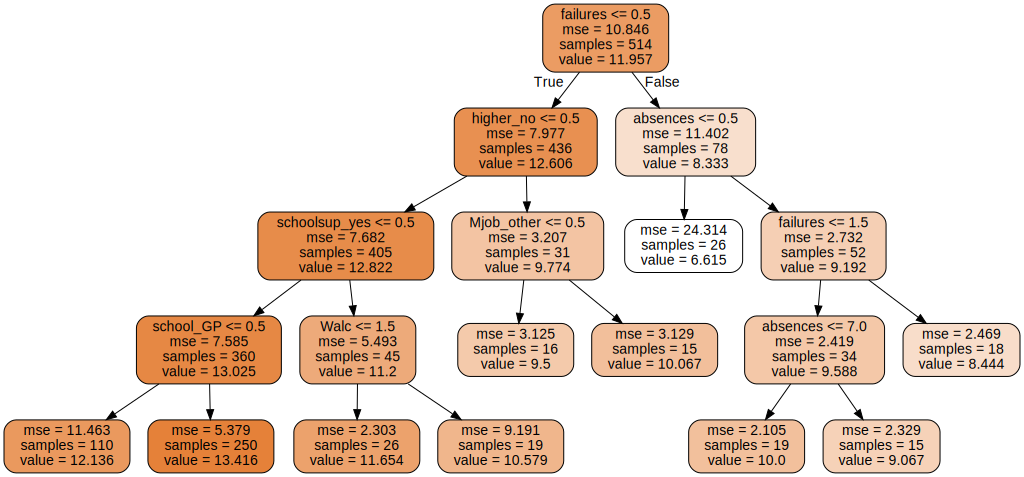

In [29]:
# visualizing decision tree
print(train_por.columns[:-1])
#create tree and display it
tree_picture = tree.export_graphviz(tree_por,
                    feature_names=train_por.columns[:57],
                    class_names=tree_por.classes_,out_file=None,
                    filled=True, rounded=True)
graphviz.Source(tree_picture)

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'school_GP',
       'school_MS', 'sex_F', 'sex_M', 'address_R', 'address_U', 'famsize_GT3',
       'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Mjob_at_home', 'Mjob_health',
       'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_course', 'reason_home', 'reason_other', 'reason_reputation',
       'guardian_father', 'guardian_mother', 'guardian_other', 'schoolsup_no',
       'schoolsup_yes', 'famsup_no', 'famsup_yes', 'paid_no', 'paid_yes',
       'activities_no', 'activities_yes', 'nursery_no', 'nursery_yes',
       'higher_no', 'higher_yes', 'internet_no', 'internet_yes',
       'romantic_no'],
      dtype='object')


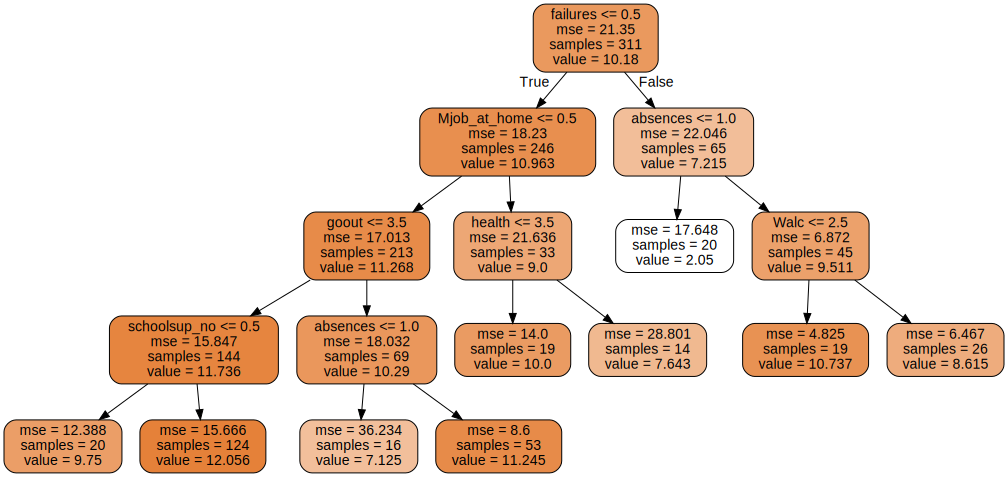

In [30]:
print(train_mat.columns[:-1])
#create tree and display it
tree_picture = tree.export_graphviz(tree_mat,
                    feature_names=train_mat.columns[:57],
                    class_names=tree_mat.classes_,out_file=None,
                    filled=True, rounded=True)
graphviz.Source(tree_picture)

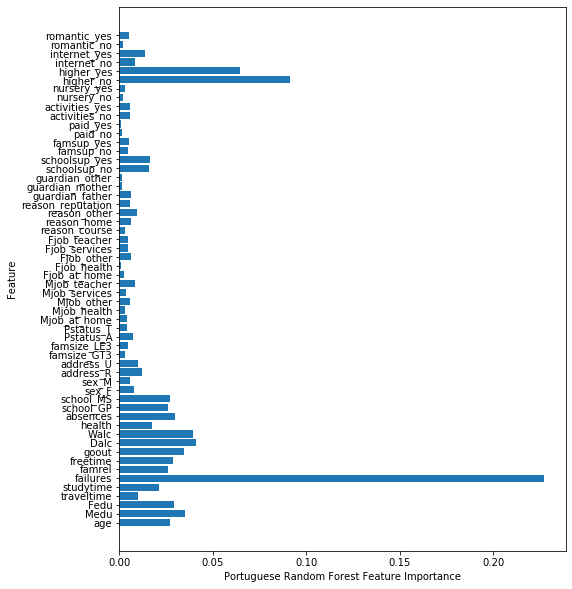

In [31]:

# It looks like our random forest model achieved pretty good accuracy. 
# Now lets check how important each of the features was in the ensemble of models we built.

index = range(len(predictors)) #creates a list of numbers the right size to use as the index

plt.figure(figsize=(8,10)) #making the table a bit bigger so the text is readable
plt.barh(index,forest_por.feature_importances_,height=0.8) #horizontal bar chart
plt.ylabel('Feature')
plt.yticks(index,predictors) #put the feature names at the y tick marks
plt.xlabel("Portuguese Random Forest Feature Importance")
plt.show()

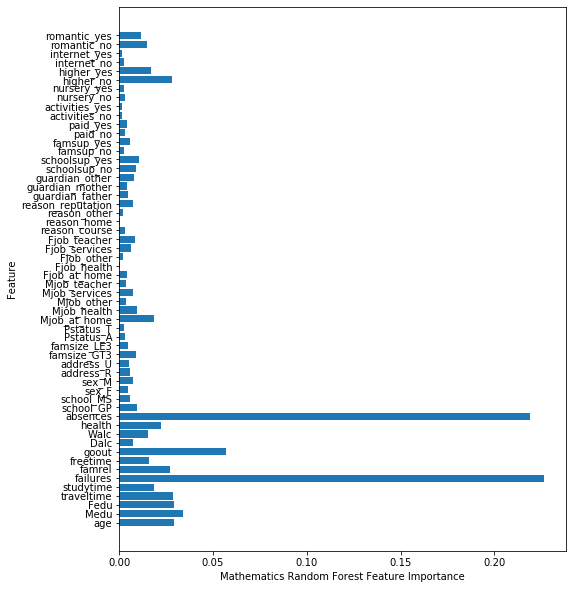

In [32]:
plt.figure(figsize=(8,10)) #making the table a bit bigger so the text is readable
plt.barh(index,forest_mat.feature_importances_,height=0.8) #horizontal bar chart
plt.ylabel('Feature')
plt.yticks(index,predictors) #put the feature names at the y tick marks
plt.xlabel("Mathematics Random Forest Feature Importance")
plt.show()